<h1>Imports</h1>

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option("display.max_columns", 100)
%matplotlib inline

<h1>Dataset Importing</h1>

In [3]:
DATA_PATH = Path.cwd() / "../../datasets"

In [4]:
training_df = pd.read_csv(DATA_PATH / "train.csv", index_col="tripid")
training_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


<h1>Data Preprocessing</h1>

In [5]:
training_df['pickup_time'] = pd.to_datetime(training_df['pickup_time'], format="%m/%d/%Y %H:%M")
training_df['drop_time'] = pd.to_datetime(training_df['drop_time'], format="%m/%d/%Y %H:%M")

<h1>Initial Data Analyisis</h1>

In [6]:
training_df.dtypes

additional_fare                     float64
duration                            float64
meter_waiting                       float64
meter_waiting_fare                  float64
meter_waiting_till_pickup           float64
pickup_time                  datetime64[ns]
drop_time                    datetime64[ns]
pick_lat                            float64
pick_lon                            float64
drop_lat                            float64
drop_lon                            float64
fare                                float64
label                                object
dtype: object

<h3>Null variable Analysis</h3>

In [7]:
training_df.isna().sum()

additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         137
label                          0
dtype: int64

In [8]:
NaNRows = training_df[training_df.isnull().any(axis=1)]

In [9]:
NaNRows['label'].value_counts()

incorrect    155
correct       53
Name: label, dtype: int64

In [10]:
NaNRows[NaNRows['fare'].isnull()]['label'].value_counts()

incorrect    137
Name: label, dtype: int64

<b>All Rows with unspecified fare are incorrect<b>

In [11]:
FareNotnull = NaNRows[NaNRows['fare'].notnull()]

In [12]:
FareNotnull[FareNotnull['label'] == 'incorrect']

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189231599,NaN,NaN,NaN,NaN,NaN,2019-11-01 14:48:00,2019-11-01 15:03:00,7.04783,79.8973,7.05307,79.9188,196.50,incorrect
189393356,NaN,NaN,NaN,NaN,NaN,2019-11-02 13:29:00,2019-11-02 13:55:00,7.21158,79.8401,7.20136,79.8455,188.71,incorrect
194813974,NaN,NaN,NaN,NaN,NaN,2019-11-25 15:30:00,2019-11-25 15:57:00,6.80195,79.8881,6.71367,79.9075,60.95,incorrect
194815238,NaN,NaN,NaN,NaN,NaN,2019-11-25 15:31:00,2019-11-25 16:50:00,7.30156,80.6668,7.21541,80.6023,84.11,incorrect
194817827,NaN,NaN,NaN,NaN,NaN,2019-11-25 15:32:00,2019-11-25 15:43:00,7.32541,80.6607,7.32674,80.6370,18.42,incorrect
194816937,NaN,NaN,NaN,NaN,NaN,2019-11-25 15:35:00,2019-11-25 15:50:00,6.04798,80.2253,6.02484,80.2185,423.90,incorrect
194840838,NaN,NaN,NaN,NaN,NaN,2019-11-25 16:12:00,2019-11-25 17:45:00,6.92088,79.9696,6.93718,79.8495,691.34,incorrect
194849570,NaN,NaN,NaN,NaN,NaN,2019-11-25 16:31:00,2019-11-25 17:31:00,6.93271,79.8429,7.00097,79.8805,380.56,incorrect
194879912,NaN,NaN,NaN,NaN,NaN,2019-11-25 17:14:00,2019-11-25 17:40:00,7.29920,80.6345,7.28688,80.6331,138.02,incorrect


In [13]:
training_df.isna().head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,False,False,False,False,False,False,False,False,False,False,False,False,False
189125358,False,False,False,False,False,False,False,False,False,False,False,False,False
189125719,False,False,False,False,False,False,False,False,False,False,False,False,False
189127273,False,False,False,False,False,False,False,False,False,False,False,False,False
189128020,True,True,True,True,True,False,False,False,False,False,False,False,False


<h2>Initial Feature Correlation</h2>

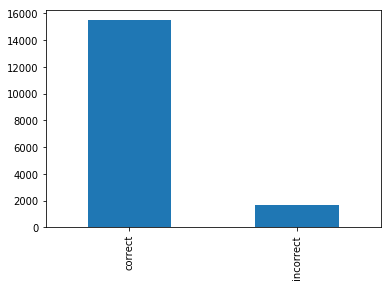

In [14]:
training_df["label"].value_counts().plot.bar()

In [15]:
training_df.groupby('label').mean()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare
label,,,,,,,,,,
correct,12.444340,1413.967232,356.655679,16.909938,107.549152,6.963470,79.995366,6.966993,79.993939,277.626009
incorrect,26.574315,4614.772193,3374.953655,184.741223,162.035248,6.984207,80.026255,6.983281,80.030669,664.197850


<h1>Initial Data Cleaning</h1>

In [16]:
training_df.duplicated(subset=None, keep='first')

tripid
189123628    False
189125358    False
189125719    False
189127273    False
189128020    False
189129552    False
189132829    False
189135103    False
189139296    False
189138671    False
189135814    False
189140969    False
189144528    False
189147041    False
189145904    False
189146174    False
189150541    False
189153229    False
189151585    False
189157464    False
189157607    False
189157476    False
189157559    False
189159951    False
189158726    False
189160756    False
189161377    False
189163162    False
189164454    False
189164880    False
             ...  
213747503    False
213751620    False
213749432    False
213754172    False
213758346    False
213759061    False
213761623    False
213776255    False
213774316    False
213774593    False
213775846    False
213774642    False
213774742    False
213779882    False
213782178    False
213782382    False
213784559    False
213784596    False
213787716    False
213789771    False
213795752    False
21379

<h1>Feature Engineering</h1>

In [17]:
training_df = training_df.assign(timeOfDay=pd.cut(training_df.pickup_time.dt.hour,[-1, 8, 20, 24],labels=['Dawn-Charge','Day-Charge', 'Night-Charge']))

In [18]:
training_df['time_dif'] = (training_df['drop_time'] - training_df['pickup_time']).dt.seconds


In [19]:
def dist_from_coordinates(lat1, lon1, lat2, lon2):
  R = 6371  # Earth radius in km

  #conversion to radians
  d_lat = np.radians(lat2-lat1)
  d_lon = np.radians(lon2-lon1)

  r_lat1 = np.radians(lat1)
  r_lat2 = np.radians(lat2)

  #haversine formula
  a = np.sin(d_lat/2.) **2 + np.cos(r_lat1) * np.cos(r_lat2) * np.sin(d_lon/2.)**2

  haversine = 2 * R * np.arcsin(np.sqrt(a))

  return haversine

In [20]:
new_column = []                    #empty column for distance
for index,row in training_df.iterrows():
  lat1 = row['pick_lat'] #first row of location.lat column here
  lon1 = row['pick_lon'] #first row of location.long column here
  lat2 = row['drop_lat'] #second row of location.lat column here
  lon2 = row['drop_lon'] #second row of location.long column here
  value = dist_from_coordinates(lat1, lon1, lat2, lon2)  #get the distance
  new_column.append(value)   #append the empty list with distance values

training_df.insert(4,"Distance",new_column)

In [21]:
training_df['avg_speed'] = (training_df['Distance'] /  ( training_df['time_dif']) * 3600 )

In [22]:
training_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,Distance,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,timeOfDay,time_dif,avg_speed
tripid,,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.000000,5.092770,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,correct,Dawn-Charge,840,21.826157
189125358,10.5,791.0,47.0,0.000000,3.168058,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,correct,Dawn-Charge,780,14.621804
189125719,10.5,1087.0,80.0,0.000000,6.305395,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,correct,Dawn-Charge,1080,21.017984
189127273,10.5,598.0,271.0,15.663800,0.861946,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,correct,Dawn-Charge,600,5.171677
189128020,NaN,NaN,NaN,NaN,8.147782,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,correct,Dawn-Charge,1020,28.756878
189129552,10.5,3407.0,182.0,0.000000,24.207039,112.0,2019-11-01 05:38:00,2019-11-01 06:35:00,7.13402,79.8969,6.91865,79.8649,1065.02,correct,Dawn-Charge,3420,25.481094
189132829,10.5,1246.0,487.0,0.000000,4.777624,133.0,2019-11-01 06:29:00,2019-11-01 06:49:00,6.84371,79.9051,6.85069,79.8624,266.62,correct,Dawn-Charge,1200,14.332871
189135103,10.5,1333.0,295.0,17.198500,5.322544,212.0,2019-11-01 06:50:00,2019-11-01 07:12:00,6.90760,79.9524,6.90634,79.9042,318.05,correct,Dawn-Charge,1320,14.516028
189139296,10.5,360.0,80.0,4.664000,1.035302,3.0,2019-11-01 07:00:00,2019-11-01 07:06:00,7.26706,80.6064,7.27422,80.6124,100.32,correct,Dawn-Charge,360,10.353018


<h1>Post feature engineering Analysis</h1>

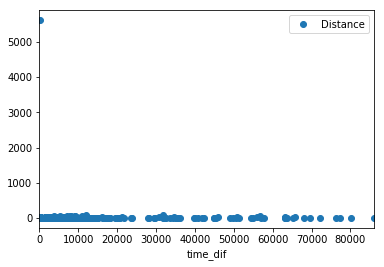

In [23]:
training_df.plot(x='time_dif', y='Distance', style='o')

In [ ]:
training_df['avg_speed'].plot()

In [26]:
training_df.nlargest(10,'Distance')

,additional_fare,duration,meter_waiting,meter_waiting_fare,Distance,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,timeOfDay,time_dif,avg_speed
tripid,,,,,,,,,,,,,,,,,
190167541,10.5,313.0,50.0,2.915000,5609.521440,98.0,2019-11-06 09:37:00,2019-11-06 09:42:00,7.46897,80.6227,48.13200,45.3077,63.41,correct,Day-Charge,300,67314.257279
209981901,10.5,31921.0,8364.0,483.439200,79.220774,38.0,2020-01-16 06:27:00,2020-01-16 15:19:00,6.82345,79.9625,6.51834,80.6107,6524.06,incorrect,Dawn-Charge,31920,8.934674
210159461,10.5,11992.0,1702.0,98.396884,76.782309,3.0,2020-01-16 15:48:00,2020-01-16 19:07:00,6.90130,79.9567,7.57333,79.7967,3649.64,correct,Day-Charge,11940,23.150445
193898575,10.5,56607.0,9998.0,577.884400,69.286259,2682.0,2019-11-22 18:20:00,2019-11-23 10:04:00,6.77160,79.9331,7.38578,80.0390,6031.06,incorrect,Day-Charge,56640,4.403788
208649108,10.5,176620.0,176164.0,10173.378000,63.185874,10.0,2020-01-10 14:34:00,2020-01-12 15:38:00,6.84841,79.9252,6.32008,80.1358,13350.32,incorrect,Day-Charge,3840,59.236757
203475249,10.5,9271.0,790.0,45.662000,58.717991,115.0,2019-12-23 18:33:00,2019-12-23 21:08:00,6.84642,79.9487,7.31178,80.2002,2841.27,correct,Day-Charge,9300,22.729545
201211325,10.5,7915.0,1291.0,74.649889,51.485228,165.0,2019-12-16 15:29:00,2019-12-16 17:41:00,6.91411,79.8962,6.45803,79.9766,2542.57,correct,Day-Charge,7920,23.402376
208638800,10.5,11116.0,2641.0,152.649800,49.852034,40.0,2020-01-10 13:29:00,2020-01-10 16:34:00,7.20146,79.8438,6.82442,80.0882,2969.77,correct,Day-Charge,11100,16.168227
201167648,10.5,8216.0,807.0,0.000000,45.027371,96.0,2019-12-16 12:08:00,2019-12-16 14:25:00,6.87183,79.8709,6.96817,80.2671,2098.00,correct,Day-Charge,8220,19.720016


In [ ]:
training_df = training_df.drop(index=190167541)

In [ ]:
training_df['avg_speed'].plot()

<h1>Post feature engineering Data cleaning</h1>